In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer



In [6]:
# 1. 数据加载和预处理
data = pd.read_csv("/content/drive/MyDrive/uibe/full_movies_ratings_data_v3.csv")
data = data.sort_values(by=['user_id', 'review_date'])

# 将review_date转换为datetime类型
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month

# 2. 特征工程
# 使用LabelEncoder编码用户和电影ID
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
data['user_id_encoded'] = user_encoder.fit_transform(data['user_id'])
data['movie_id_encoded'] = movie_encoder.fit_transform(data['tconst'])

# 创建特征列表
categorical_features = ['directors', 'cast', 'genres']
numerical_features = ['year', 'review_year', 'review_month', 'numVotes']

# 添加用户评分数量
user_rating_count = data.groupby('user_id')['rating'].count()
data['user_rating_count'] = data['user_id'].map(user_rating_count)

# 添加电影评分数量
movie_rating_count = data.groupby('tconst')['rating'].count()
data['movie_rating_count'] = data['tconst'].map(movie_rating_count)

# 添加用户和电影的评分标准差
user_rating_std = data.groupby('user_id')['rating'].std().fillna(0)
data['user_rating_std'] = data['user_id'].map(user_rating_std)

# 添加用户-电影交互特征
data['user_movie_rating_diff'] = data['rating'] - data.groupby(['user_id', 'tconst'])['rating'].transform('mean')

# 添加时间特征
data['days_since_release'] = (data['review_date'] - pd.to_datetime(data['year'], format='%Y')).dt.days

# Temporal features
data['quarter'] = data['review_date'].dt.quarter
data['day_of_week'] = data['review_date'].dt.dayofweek
data['days_since_last_review'] = data.groupby('user_id')['review_date'].diff().dt.days.fillna(0)
data['hour_of_day'] = data['review_date'].dt.hour
data['week_of_year'] = data['review_date'].dt.isocalendar().week

# User-item interaction features
data['user_total_ratings'] = data.groupby('user_id')['rating'].transform('count')
data['movie_total_ratings'] = data.groupby('tconst')['rating'].transform('count')

# 添加噪声特征
np.random.seed(42)
data['noise_feature'] = np.random.normal(size=len(data))

# 添加时序特征
data['user_rating_ewma'] = data.groupby('user_id')['rating'].transform(lambda x: x.ewm(span=5).mean())
data['movie_rating_ewma'] = data.groupby('tconst')['rating'].transform(lambda x: x.ewm(span=5).mean())
# 添加序列特征（这里需要自定义函数来创建序列）
def get_last_n_ratings(group, n=5):
    return group.sort_values('review_date')['rating'].iloc[-n:].tolist()

data['user_last_5_ratings'] = data.groupby('user_id').apply(get_last_n_ratings).reset_index(level=0, drop=True)

# 添加交互特征
data['user_genre_avg_rating'] = data.groupby(['user_id', 'genres'])['rating'].transform('mean')

# 添加周期性特征
data['hour_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)

# 添加噪声特征
data['noise_feature'] = np.random.normal(0, 0.1, size=len(data))

# 更新数值特征列表
numerical_features += ['user_rating_count', 'movie_rating_count', 'days_since_release', 'user_movie_rating_diff', 'user_rating_std', 'user_total_ratings', 'movie_total_ratings', 'days_since_last_review', 'hour_of_day', 'week_of_year']
numerical_features += ['user_rating_ewma', 'movie_rating_ewma', 'user_genre_avg_rating', 'hour_sin', 'hour_cos', 'noise_feature']

# 创建ColumnTransformer进行One-Hot编码和标准化
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=100), categorical_features)
    ])

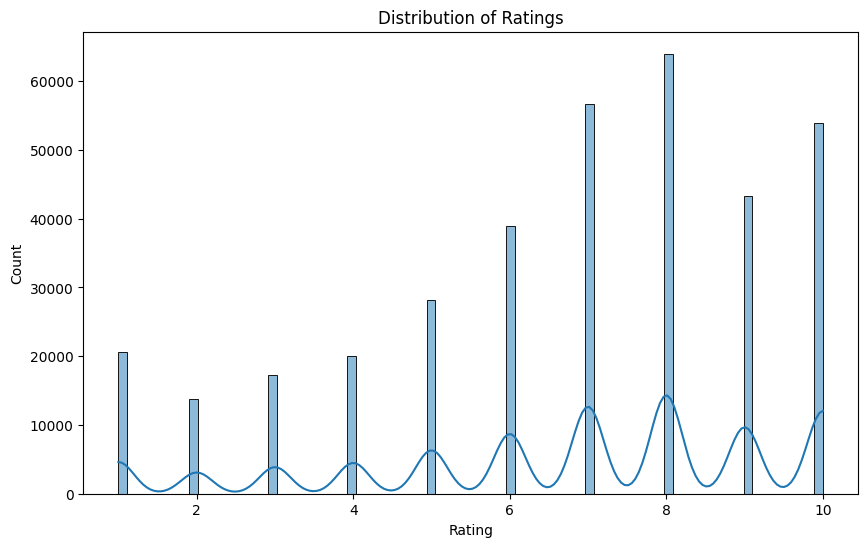

Rating Distribution Statistics:
count    356576.000000
mean          6.704733
std           2.587532
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 评分分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 输出评分分布的描述性统计
print("Rating Distribution Statistics:")
print(data['rating'].describe())

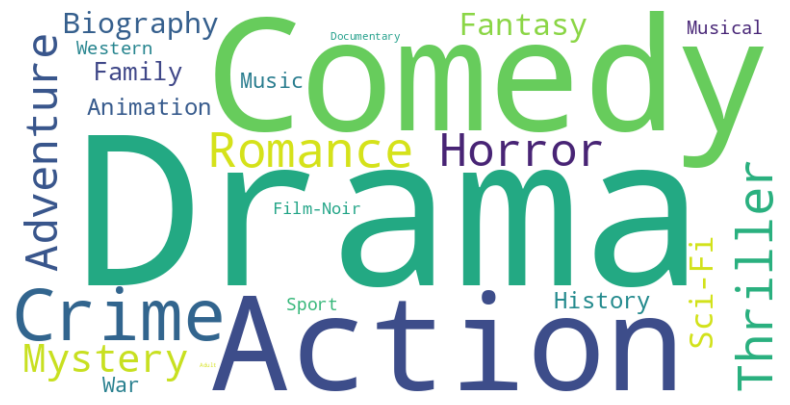

In [8]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 分割每行的类别，并合并成一个列表
all_genres = []
for genres in data['genres']:
    all_genres.extend(genres.split(','))

# 对类别去重
unique_genres = list(set(all_genres))

# 生成类别的词频
genre_counts = Counter(all_genres)

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_counts)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

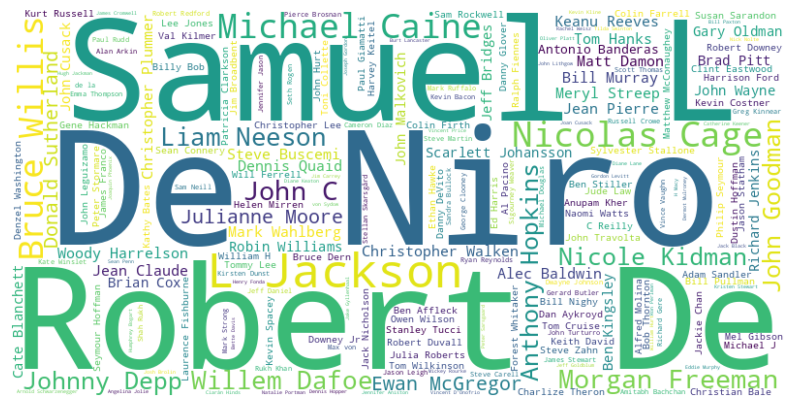

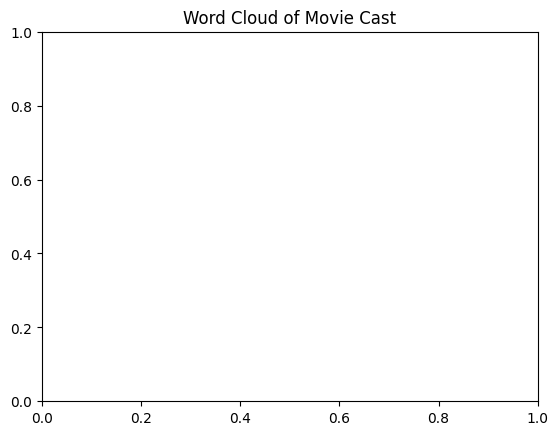

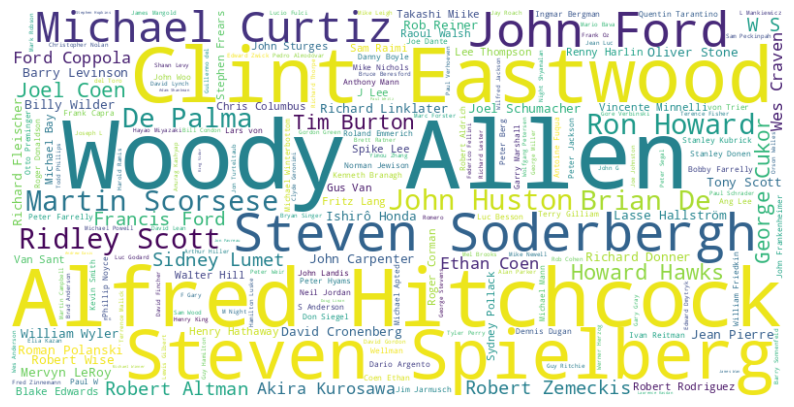

Text(0.5, 1.0, 'Word Cloud of Movie Directors')

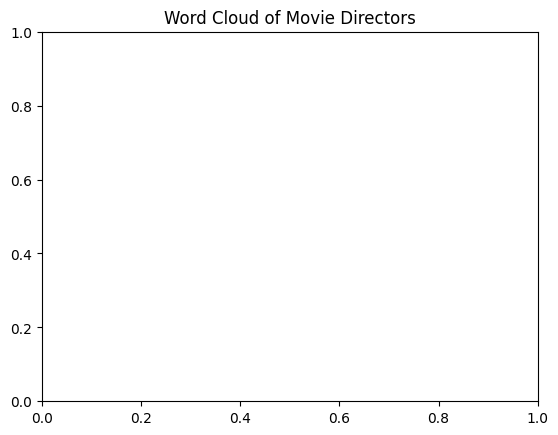

In [9]:


from wordcloud import WordCloud

def create_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 演员词云
cast_text = ' '.join(data['cast'].explode().fillna(''))
create_wordcloud(cast_text)
plt.title('Word Cloud of Movie Cast')

# 导演词云
directors_text = ' '.join(data['directors'].explode().fillna(''))
create_wordcloud(directors_text)
plt.title('Word Cloud of Movie Directors')

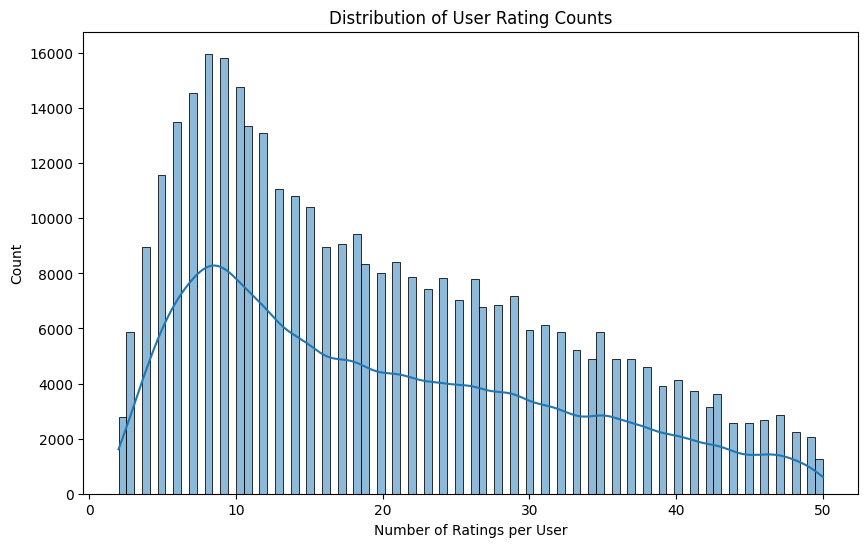


User Rating Count Statistics:
count    356576.000000
mean         19.846176
std          12.184186
min           2.000000
25%          10.000000
50%          17.000000
75%          29.000000
max          50.000000
Name: user_rating_count, dtype: float64


In [10]:
# 2. 用户评分数量分布
plt.figure(figsize=(10, 6))
sns.histplot(data['user_rating_count'], kde=True)
plt.title('Distribution of User Rating Counts')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Count')
plt.show()

# 输出用户评分数量的描述性统计
print("\nUser Rating Count Statistics:")
print(data['user_rating_count'].describe())

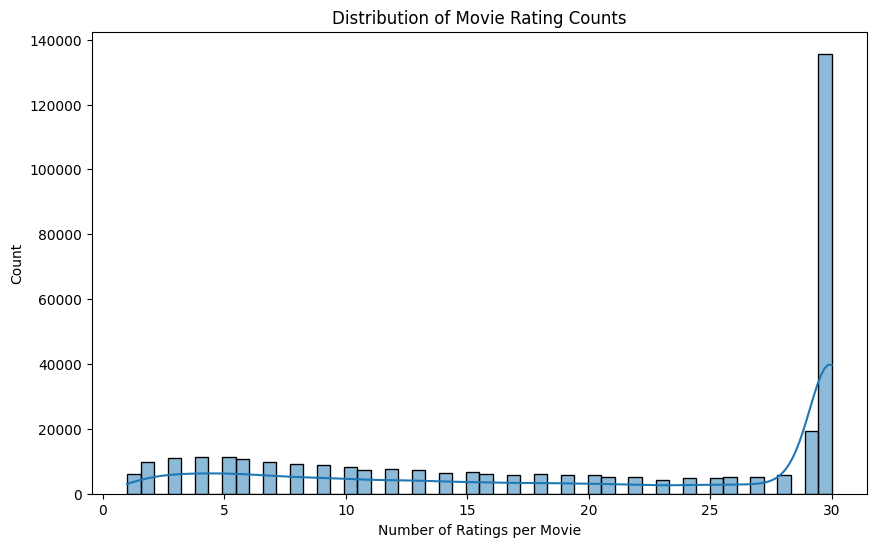


Movie Rating Count Statistics:
count    356576.000000
mean         20.030759
std          10.479660
min           1.000000
25%          10.000000
50%          24.000000
75%          30.000000
max          30.000000
Name: movie_rating_count, dtype: float64


In [11]:
# 3. 电影评分数量分布
plt.figure(figsize=(10, 6))
sns.histplot(data['movie_rating_count'], kde=True)
plt.title('Distribution of Movie Rating Counts')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Count')
plt.show()

# 输出电影评分数量的描述性统计
print("\nMovie Rating Count Statistics:")
print(data['movie_rating_count'].describe())

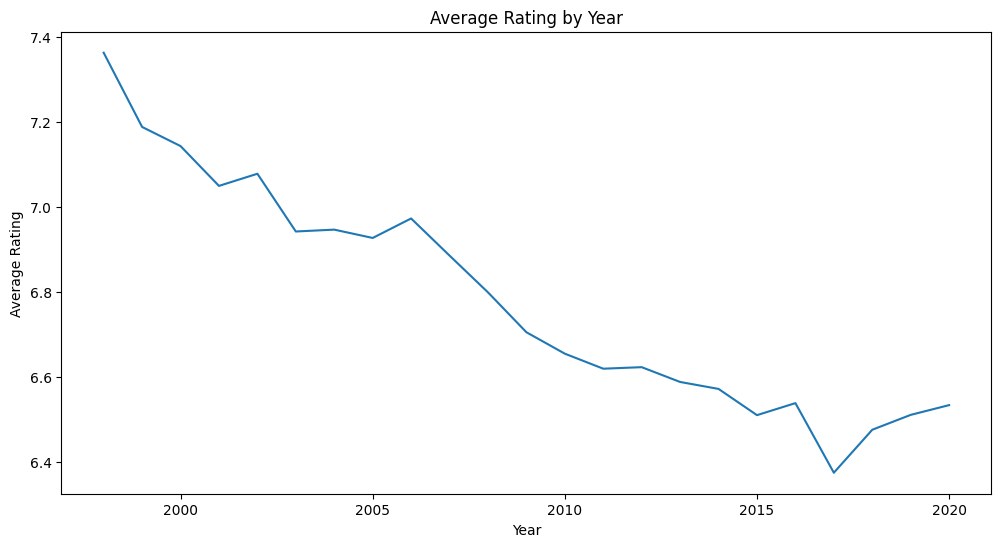


Average Rating by Year:
    review_year    rating
0          1998  7.362214
1          1999  7.187673
2          2000  7.142674
3          2001  7.049037
4          2002  7.077598
5          2003  6.941799
6          2004  6.946184
7          2005  6.926595
8          2006  6.972445
9          2007  6.885132
10         2008  6.798675
11         2009  6.704877
12         2010  6.654486
13         2011  6.619142
14         2012  6.622738
15         2013  6.587941
16         2014  6.571591
17         2015  6.509891
18         2016  6.538207
19         2017  6.374512
20         2018  6.475584
21         2019  6.510553
22         2020  6.533506


In [12]:
# 4. 评分随时间变化的趋势
data_grouped = data.groupby('review_year')['rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='review_year', y='rating', data=data_grouped)
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

# 输出每年的平均评分
print("\nAverage Rating by Year:")
print(data_grouped)

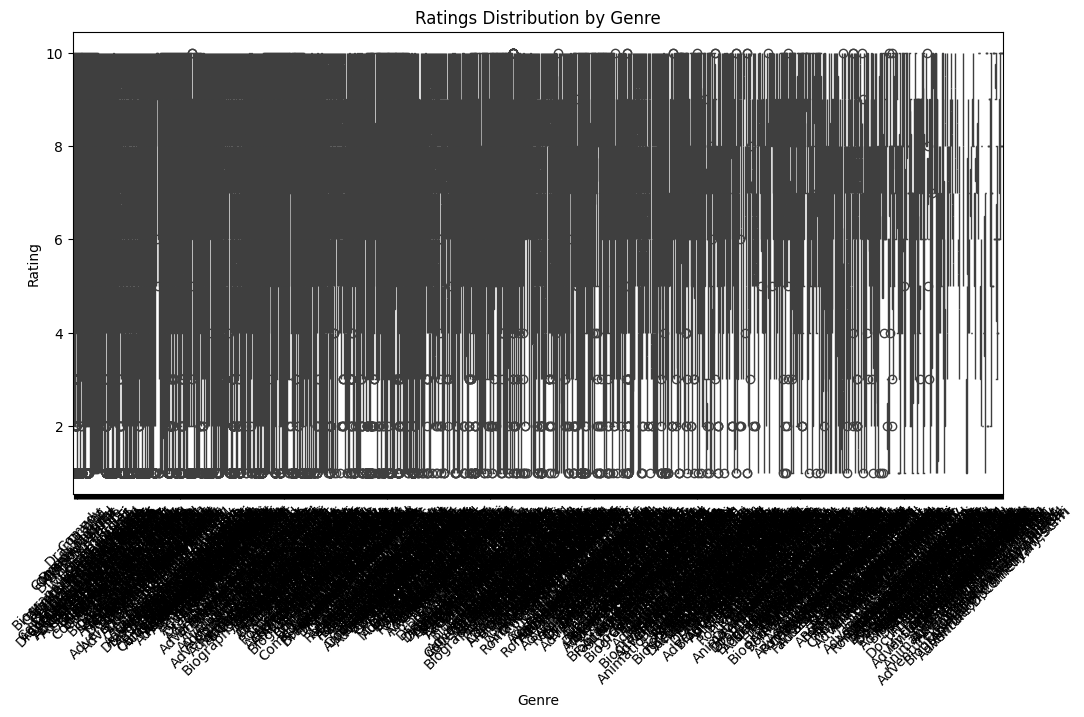


Ratings Statistics by Genre:
                             count      mean       std  min   25%  50%   75%  \
genres                                                                         
Action                       342.0  5.616959  2.818467  1.0  3.00  6.0  8.00   
Action,Adult,Drama             3.0  3.333333  2.516611  1.0  2.00  3.0  4.50   
Action,Adventure             359.0  6.958217  2.606595  1.0  5.00  8.0  9.00   
Action,Adventure,Animation  2709.0  7.061277  2.411034  1.0  6.00  7.0  9.00   
Action,Adventure,Biography   312.0  6.868590  2.445294  1.0  5.00  7.0  9.00   
...                            ...       ...       ...  ...   ...  ...   ...   
War                           10.0  7.400000  1.264911  6.0  6.25  7.0  8.75   
War,Documentary                4.0  8.250000  2.217356  5.0  8.00  9.0  9.25   
War,Thriller                  57.0  7.403509  1.801385  2.0  6.00  8.0  8.00   
War,Western                   45.0  6.355556  2.257871  1.0  5.00  7.0  8.00   
Western   

In [13]:
# 5. 热门电影类型的评分箱线图
plt.figure(figsize=(12, 6))
sns.boxplot(x='genres', y='rating', data=data)
plt.title('Ratings Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

# 输出每个类型的评分统计
print("\nRatings Statistics by Genre:")
print(data.groupby('genres')['rating'].describe())

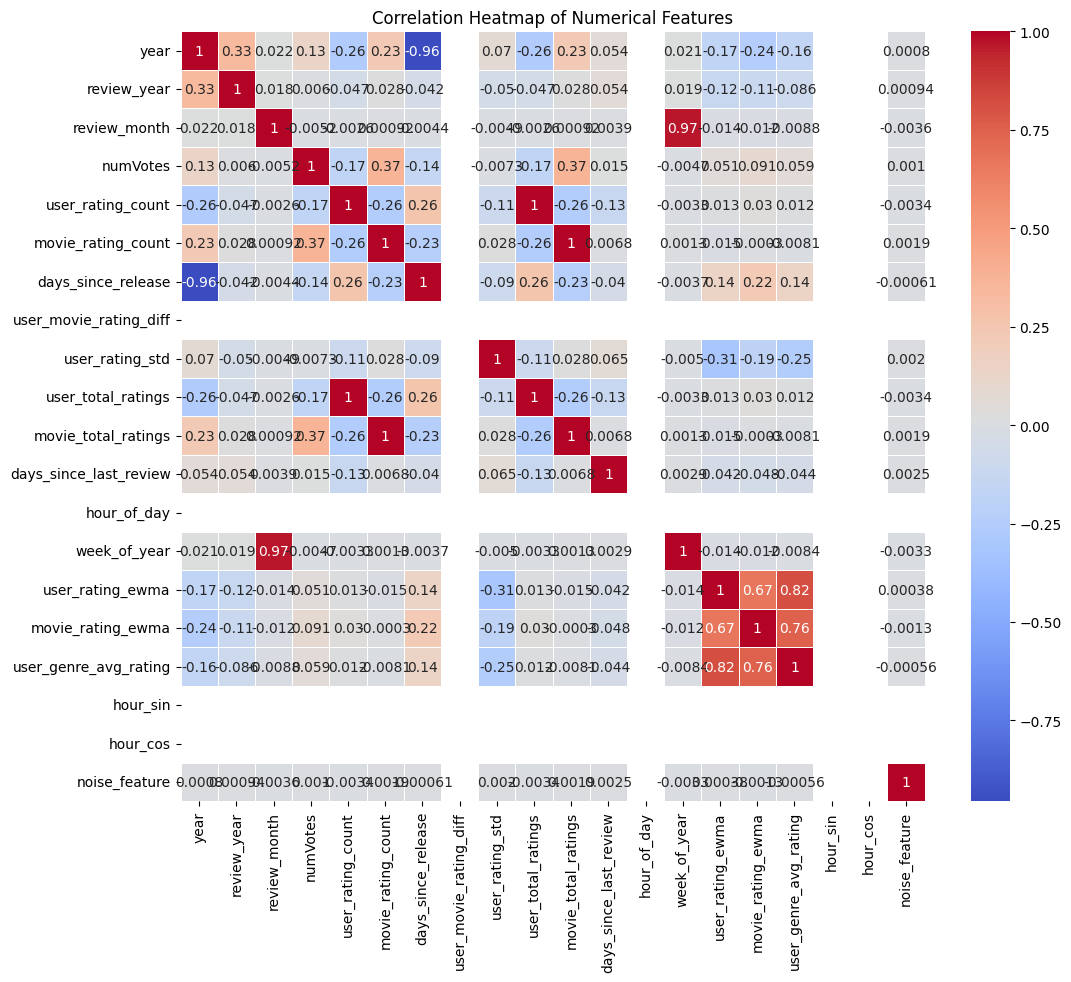


Correlation Matrix:
                            year  review_year  review_month  numVotes  \
year                    1.000000     0.334012      0.021899  0.132355   
review_year             0.334012     1.000000      0.017895  0.005973   
review_month            0.021899     0.017895      1.000000 -0.005176   
numVotes                0.132355     0.005973     -0.005176  1.000000   
user_rating_count      -0.263463    -0.047317     -0.002629 -0.172612   
movie_rating_count      0.228794     0.027767      0.000920  0.373088   
days_since_release     -0.955814    -0.042447     -0.004416 -0.138519   
user_movie_rating_diff       NaN          NaN           NaN       NaN   
user_rating_std         0.069817    -0.049761     -0.004850 -0.007274   
user_total_ratings     -0.263463    -0.047317     -0.002629 -0.172612   
movie_total_ratings     0.228794     0.027767      0.000920  0.373088   
days_since_last_review  0.053775     0.053879      0.003941  0.014931   
hour_of_day                  N

In [14]:
# 6. 相关性热力图
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# 输出相关性矩阵
print("\nCorrelation Matrix:")
print(correlation_matrix)

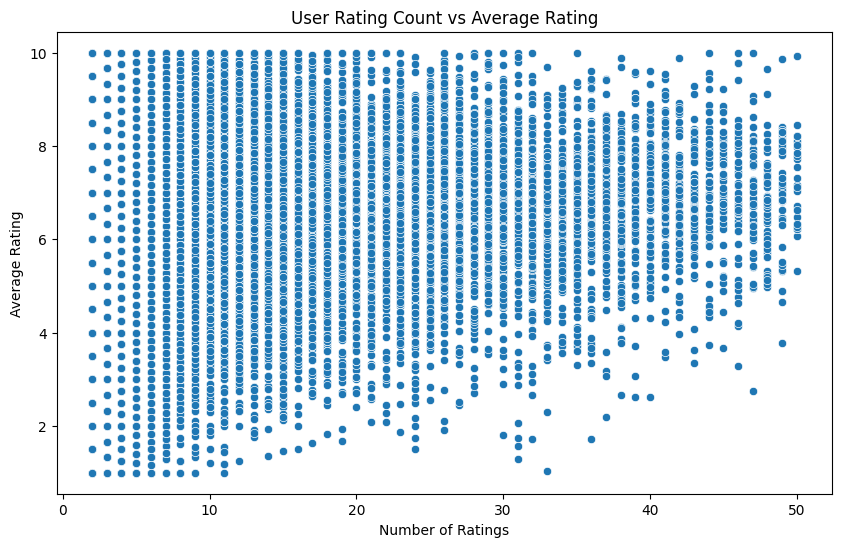


User Statistics (first few rows):
     user_id  rating_count  avg_rating
0  ur0000011            33    5.848485
1  ur0000039             6    4.666667
2  ur0000066             2    9.500000
3  ur0000157             9    7.444444
4  ur0000685            20    7.450000


In [15]:
# 7. 用户评分数量与平均评分的散点图
user_stats = data.groupby('user_id').agg({'rating': ['count', 'mean']}).reset_index()
user_stats.columns = ['user_id', 'rating_count', 'avg_rating']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating_count', y='avg_rating', data=user_stats)
plt.title('User Rating Count vs Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

# 输出用户统计数据的前几行
print("\nUser Statistics (first few rows):")
print(user_stats.head())

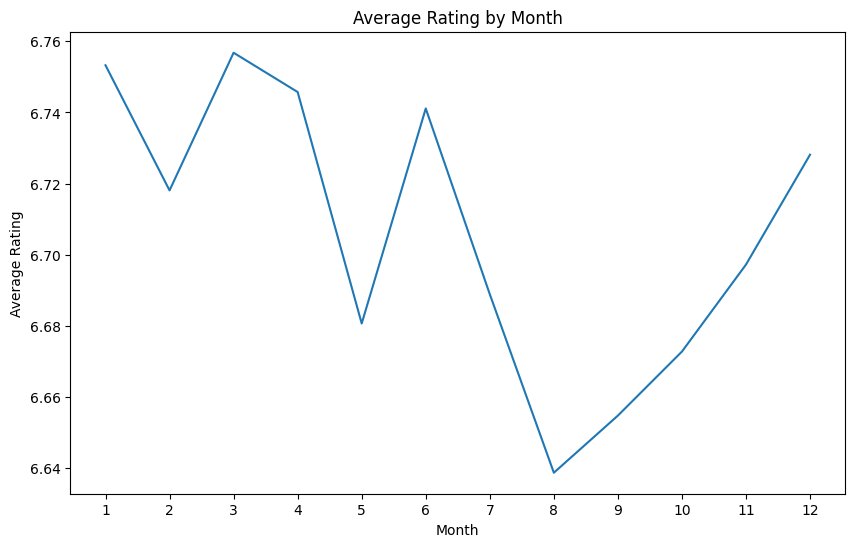


Average Rating by Month:
    month    rating
0       1  6.753274
1       2  6.718087
2       3  6.756798
3       4  6.745743
4       5  6.680656
5       6  6.741122
6       7  6.688883
7       8  6.638699
8       9  6.654766
9      10  6.672770
10     11  6.697233
11     12  6.728129


In [16]:
# 8. 评分的季节性趋势
data['month'] = data['review_date'].dt.month
monthly_ratings = data.groupby('month')['rating'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='rating', data=monthly_ratings)
plt.title('Average Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(range(1, 13))
plt.show()

# 输出每月平均评分
print("\nAverage Rating by Month:")
print(monthly_ratings)

In [17]:
# 3. 准备输入数据
X = data[['user_id_encoded', 'movie_id_encoded'] + numerical_features + categorical_features]
y = data['rating'].values

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# 拟合和转换特征
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [19]:
print(f"Number of features: {X_train_processed.shape[1] - 2}")

print(f"User input shape: {X_train['user_id_encoded'].shape}")
print(f"Movie input shape: {X_train['movie_id_encoded'].shape}")
print(f"Features input shape: {X_train_processed[:, 2:].shape}")

Number of features: 318
User input shape: (285260,)
Movie input shape: (285260,)
Features input shape: (285260, 318)


In [20]:
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_improved_model(num_users, num_movies, num_features):
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    features_input = Input(shape=(num_features,), name='features_input')  # 这里使用正确的 num_features

    user_embedding = Embedding(input_dim=num_users, output_dim=32, embeddings_regularizer=l2(1e-6))(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=32, embeddings_regularizer=l2(1e-6))(movie_input)

    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)

    concat = Concatenate()([user_vec, movie_vec, features_input])

    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(1e-6))(concat)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu', kernel_regularizer=l2(1e-6))(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output = Dense(1)(dropout2)

    model = Model(inputs=[user_input, movie_input, features_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

    return model

num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)
num_features = X_train_processed.shape[1] - 2

model = create_improved_model(num_users, num_movies, num_features)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    [X_train['user_id_encoded'], X_train['movie_id_encoded'], X_train_processed[:, 2:]],
    y_train,
    epochs=30,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
223/223 [==============================] - 15s 60ms/step - loss: 13.1219 - mae: 2.7211 - val_loss: 1.0201 - val_mae: 0.7746 - lr: 5.0000e-04
Epoch 2/30
223/223 [==============================] - 10s 46ms/step - loss: 3.3186 - mae: 1.4226 - val_loss: 0.7359 - val_mae: 0.6244 - lr: 5.0000e-04
Epoch 3/30
223/223 [==============================] - 9s 38ms/step - loss: 2.8682 - mae: 1.3150 - val_loss: 0.6999 - val_mae: 0.6054 - lr: 5.0000e-04
Epoch 4/30
223/223 [==============================] - 11s 48ms/step - loss: 2.6113 - mae: 1.2510 - val_loss: 0.6469 - val_mae: 0.5704 - lr: 5.0000e-04
Epoch 5/30
223/223 [==============================] - 13s 59ms/step - loss: 2.4776 - mae: 1.2174 - val_loss: 0.6607 - val_mae: 0.5821 - lr: 5.0000e-04
Epoch 6/30
223/223 [==============================] - 19s 85ms/step - loss: 2.3797 - mae: 1.1909 - val_loss: 0.6333 - val_mae: 0.5622 - lr: 5.0000e-04
Epoch 7/30
223/223 [==============================] - 17s 77ms/step - loss: 2.3112 - mae: 1.17

In [21]:
y_pred = model.predict([X_test['user_id_encoded'], X_test['movie_id_encoded'], X_test_processed[:, 2:]])



2229/2229 [==============================] - 4s 2ms/step


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error

def print_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)

    print(f"Metrics for {model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.2f}")
    print(f"EVS: {evs:.2f}")
    print(f"MedAE: {medae:.2f}")
    print("\n")

print_metrics(y_test, y_pred, "Attention LSTM")

Metrics for Attention LSTM:
MSE: 0.66
MAE: 0.55
R2: 0.90
EVS: 0.91
MedAE: 0.36




In [23]:
from keras.layers import LSTM, Reshape

def create_lstm_model(num_users, num_movies, num_features):
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    features_input = Input(shape=(num_features,), name='features_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=32)(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=32)(movie_input)

    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)

    lstm_input = Concatenate()([user_vec, movie_vec, features_input])
    lstm_input = Reshape((1, -1))(lstm_input)

    lstm = LSTM(32)(lstm_input)

    output = Dense(1)(lstm)

    model = Model(inputs=[user_input, movie_input, features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

lstm_model = create_lstm_model(num_users, num_movies, num_features)

history_lstm = lstm_model.fit(
    [X_train['user_id_encoded'], X_train['movie_id_encoded'], X_train_processed[:, 2:]],
    y_train,
    epochs=30,
    batch_size=1024,
    validation_split=0.2
)

# Evaluate LSTM model
y_pred_lstm = lstm_model.predict([X_test['user_id_encoded'], X_test['movie_id_encoded'], X_test_processed[:, 2:]])
print_metrics(y_test, y_pred_lstm, "LSTM without Attention")


Epoch 1/30
223/223 [==============================] - 12s 40ms/step - loss: 20.4724 - mae: 3.6091 - val_loss: 1.1202 - val_mae: 0.8227
Epoch 2/30
223/223 [==============================] - 11s 49ms/step - loss: 0.7897 - mae: 0.6746 - val_loss: 0.7430 - val_mae: 0.6476
Epoch 3/30
223/223 [==============================] - 10s 43ms/step - loss: 0.5503 - mae: 0.5507 - val_loss: 0.6874 - val_mae: 0.6120
Epoch 4/30
223/223 [==============================] - 8s 37ms/step - loss: 0.4877 - mae: 0.5111 - val_loss: 0.6744 - val_mae: 0.6000
Epoch 5/30
223/223 [==============================] - 10s 45ms/step - loss: 0.4621 - mae: 0.4935 - val_loss: 0.6675 - val_mae: 0.5929
Epoch 6/30
223/223 [==============================] - 9s 40ms/step - loss: 0.4471 - mae: 0.4826 - val_loss: 0.6638 - val_mae: 0.5889
Epoch 7/30
223/223 [==============================] - 10s 44ms/step - loss: 0.4351 - mae: 0.4749 - val_loss: 0.6572 - val_mae: 0.5834
Epoch 8/30
223/223 [==============================] - 10s 43ms/

In [24]:
!pip install surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# 准备数据
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(data[['user_id', 'tconst', 'rating']], reader)

# 分割数据
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 创建并训练模型
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd_model.fit(trainset)

# 预测
predictions = svd_model.test(testset)
y_pred_svd = [pred.est for pred in predictions]
y_true_svd = [pred.r_ui for pred in predictions]

print_metrics(y_true_svd, y_pred_svd, "SVD Matrix Factorization")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357249 sha256=057109bb955eaa1f365a9396a94be3eca576ada4870a94063dc1646ae0dd752c
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
Metrics for SVD Matrix Factorization:
MSE: 4.95
MAE: 1.74
R2: 0.26
EVS: 0.26
MedAE: 1.42




In [25]:
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam

def create_ncf_model(num_users, num_movies, embedding_size=50):
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')

    user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)

    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)

    concat = Concatenate()([user_vec, movie_vec])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    return model

ncf_model = create_ncf_model(num_users, num_movies)

history_ncf = ncf_model.fit(
    [X_train['user_id_encoded'], X_train['movie_id_encoded']],
    y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2
)

y_pred_ncf = ncf_model.predict([X_test['user_id_encoded'], X_test['movie_id_encoded']])
print_metrics(y_test, y_pred_ncf.flatten(), "Neural Collaborative Filtering")

Epoch 1/20
892/892 [==============================] - 63s 69ms/step - loss: 7.7793 - mae: 2.1330 - val_loss: 5.1138 - val_mae: 1.7711
Epoch 2/20
892/892 [==============================] - 42s 47ms/step - loss: 4.2400 - mae: 1.5870 - val_loss: 5.0639 - val_mae: 1.7209
Epoch 3/20
892/892 [==============================] - 38s 42ms/step - loss: 3.7085 - mae: 1.4610 - val_loss: 5.0830 - val_mae: 1.7396
Epoch 4/20
892/892 [==============================] - 40s 45ms/step - loss: 3.0742 - mae: 1.3052 - val_loss: 5.4208 - val_mae: 1.7540
Epoch 5/20
892/892 [==============================] - 37s 42ms/step - loss: 2.1862 - mae: 1.0862 - val_loss: 5.8410 - val_mae: 1.8306
Epoch 6/20
892/892 [==============================] - 40s 45ms/step - loss: 1.3449 - mae: 0.8588 - val_loss: 6.2176 - val_mae: 1.8890
Epoch 7/20
892/892 [==============================] - 37s 42ms/step - loss: 0.8368 - mae: 0.6901 - val_loss: 6.3723 - val_mae: 1.8932
Epoch 8/20
892/892 [==============================] - 40s 44ms

In [26]:
from keras.layers import Input, Dense
from keras.models import Model

def create_autoencoder_model(input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    # Full model
    autoencoder = Model(input_layer, decoded)

    # Encoder model
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

input_dim = X_train_processed.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

# 训练AutoEncoder
autoencoder.fit(X_train_processed, X_train_processed,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

# 使用编码器获取特征
encoded_features_train = encoder.predict(X_train_processed)
encoded_features_test = encoder.predict(X_test_processed)

# 使用编码后的特征训练一个简单的回归模型
regressor = Dense(1)
regression_model = Model(inputs=encoder.input, outputs=regressor(encoder.output))
regression_model.compile(optimizer='adam', loss='mse')

regression_model.fit(X_train_processed, y_train,
                     epochs=20,
                     batch_size=256,
                     validation_split=0.2)

y_pred_autoencoder = regression_model.predict(X_test_processed)
print_metrics(y_test, y_pred_autoencoder.flatten(), "AutoEncoder + Regression")

Epoch 1/50
892/892 [==============================] - 17s 17ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 2/50
892/892 [==============================] - 10s 11ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/50
892/892 [==============================] - 12s 14ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/50
892/892 [==============================] - 12s 13ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/50
892/892 [==============================] - 8s 9ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/50
892/892 [==============================] - 7s 8ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
892/892 [==============================] - 5s 5ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
892/892 [==============================] - 6s 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
892/892 [==============================] - 6s 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/50
892/892 [==============================] - 5s 6ms/step - loss: 0.0017 - val_loss

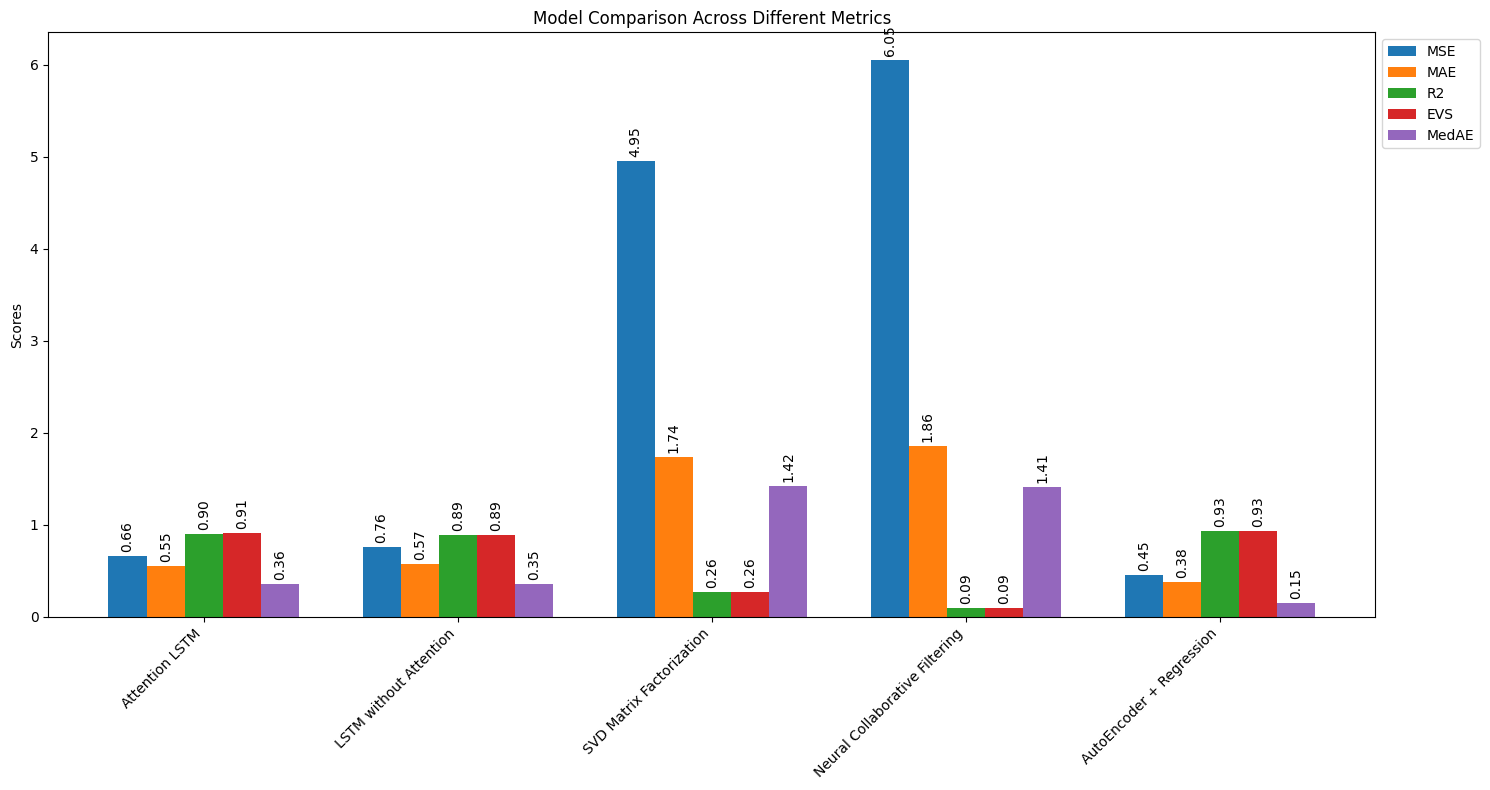

In [30]:
def get_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'EVS': explained_variance_score(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred)
    }
def plot_model_comparison(metrics_dict):
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[models[0]].keys())

    x = np.arange(len(models))
    width = 0.15
    multiplier = 0

    fig, ax = plt.subplots(figsize=(15, 8))

    for metric in metrics:
        offset = width * multiplier
        rects = ax.bar(x + offset, [metrics_dict[model][metric] for model in models], width, label=metric)
        ax.bar_label(rects, padding=3, rotation=90, fmt='%.2f')
        multiplier += 1

    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison Across Different Metrics')
    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()


metrics_dict = {
    'Attention LSTM': get_metrics(y_test, y_pred),
    'LSTM without Attention': get_metrics(y_test, y_pred_lstm),
    'SVD Matrix Factorization': get_metrics(y_true_svd, y_pred_svd),
    'Neural Collaborative Filtering': get_metrics(y_test, y_pred_ncf.flatten()),
    'AutoEncoder + Regression': get_metrics(y_test, y_pred_autoencoder.flatten())
}

plot_model_comparison(metrics_dict)

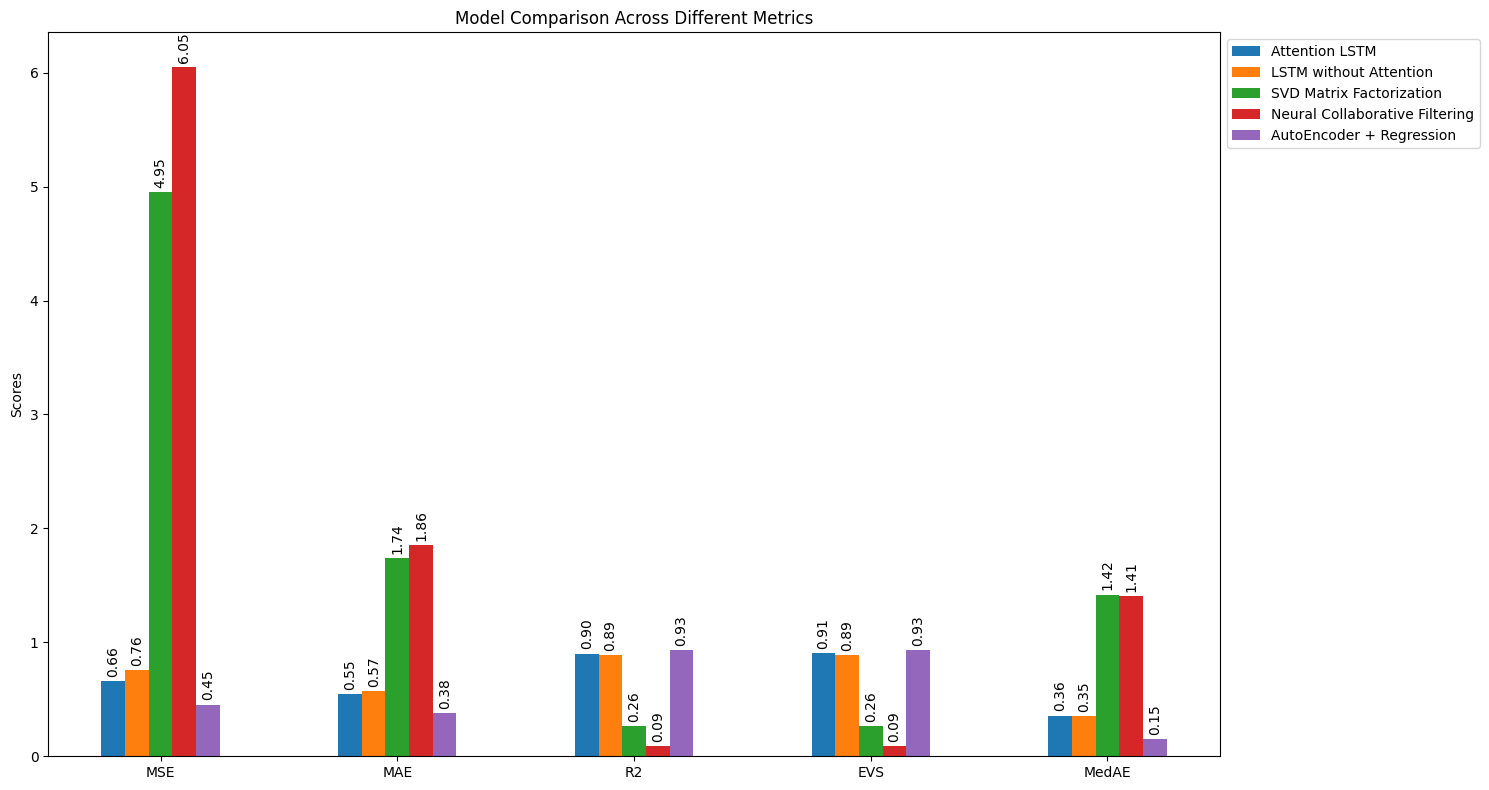

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(metrics_dict, main_model='Attention LSTM'):
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[main_model].keys())

    # 将主模型移到第一位
    models.remove(main_model)
    models = [main_model] + models

    x = np.arange(len(metrics))
    width = 0.1
    multiplier = 0

    fig, ax = plt.subplots(figsize=(15, 8))

    for i, model in enumerate(models):
        offset = width * multiplier
        rects = ax.bar(x + offset, [metrics_dict[model][metric] for metric in metrics], width, label=model)
        ax.bar_label(rects, padding=3, rotation=90, fmt='%.2f')
        multiplier += 1

    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison Across Different Metrics')
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()



metrics_dict = {
    'Attention LSTM': get_metrics(y_test, y_pred),
    'LSTM without Attention': get_metrics(y_test, y_pred_lstm),
    'SVD Matrix Factorization': get_metrics(y_true_svd, y_pred_svd),
    'Neural Collaborative Filtering': get_metrics(y_test, y_pred_ncf.flatten()),
    'AutoEncoder + Regression': get_metrics(y_test, y_pred_autoencoder.flatten())
}
# 绘制比较图
plot_model_comparison(metrics_dict)